<h1><center>Naive Bayes - Titanic survival</center></h1>
<h2><center>Probabilistic Machine Learning</center></h2>

### Dependencies

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
# Suppress warnings
warnings.filterwarnings("ignore")

### Load data

In [3]:
data = pd.read_csv('titanic_dataset.csv')

### Overview the data

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


One advantage of Bayesian models is that it works well enough with small data, having more would give you more accurate probabilities but it's not data hungry as something like deep learning.

### Pre-process
* feature selection, data cleaning, feature engineering and data imputation

In [7]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [8]:
# Drop missing values from the train set.
data.dropna(axis=0, inplace=True)
labels = data[target].values

Our processed train set

In [9]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,7.0,1,0,PC 17599,71.2833,C85,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,6.0,1,0,113803,53.1000,C123,1.0
6,7,0,1,"McCarthy, Mr. Timothy J",1,9.0,0,0,17463,51.8625,E46,1.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,0.0,1,1,PP 9549,16.7000,G6,1.0
11,12,1,1,"Bonnell, Miss. Elizabeth",0,9.0,0,0,113783,26.5500,C103,1.0


### Correlation study
* As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

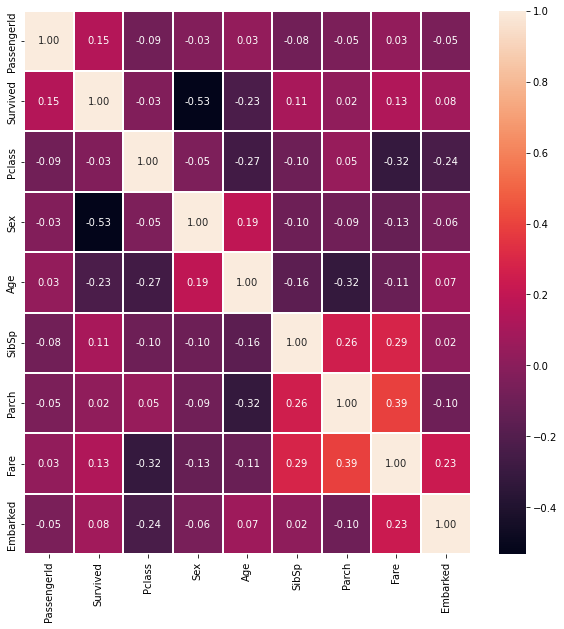

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(),  annot=True, fmt='.2f', linewidths=.2)
plt.show()

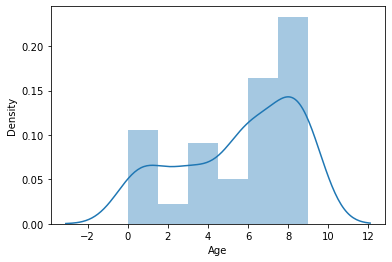

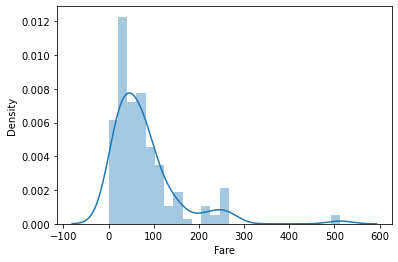

In [15]:
continuous_numeric_features = ['Age', 'Fare']
for feature in continuous_numeric_features:
    sns.distplot(data[feature])
    plt.show()

### Split data in train and validation (80% ~ 20%)

In [23]:
labels=data['Survived']
data=data.loc[:,data.columns!='Survived']

In [25]:
data.drop(columns=['Name','Ticket','Cabin'],inplace=True)

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [27]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [28]:
X_train.shape, X_val.shape,X_test.shape

((116, 8), (30, 8), (37, 8))

#### How Naive Bayes algorithm works?
* Convert the data set into a frequency table
* Create Likelihood table by finding the probabilities.
* Now, use Naive Bayesian equation to calculate the posterior probability for each class. The class with the highest posterior probability is the outcome of prediction.


##### As you can see the whole model is built upon the probabilities of events, that would be our features.

In [29]:
classifier = GaussianNB()

#### Fit the first part
* Fitting data here is really fast.

In [30]:
classifier.fit(X_train, Y_train)

GaussianNB()

In [47]:
def cross_validate(classifier, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

In [48]:
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Model metrics
Accuracy  Train: 0.78, Validation: 0.73
Recall    Train: 0.87, Validation: 0.94
Precision Train: 0.78, Validation: 0.68


### Apply the model on the test data 

In [43]:
y_pred = classifier.predict(X_test)

In [44]:
from sklearn import metrics
print("Accuracy :",metrics.accuracy_score(Y_test,y_pred))

Accuracy : 0.7027027027027027


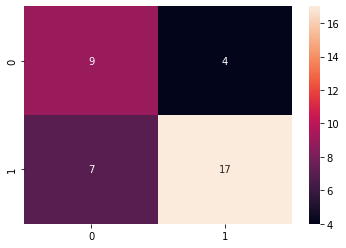

In [45]:
sns.heatmap(metrics.confusion_matrix(Y_test, y_pred),annot=True)
plt.show()